In [2]:
from datetime import datetime

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
RANDOM_SEED = 42
dataset = '../data/gestures.csv'
model_save_path = '../../gestures_classifier_test.hdf5'
NUM_CLASSES = 3

In [4]:
x_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)), skiprows=1)
for x_row in x_dataset:
    first_x = x_row[0]
    first_y = x_row[1]
    x_row[0::2] -= first_x
    x_row[1::2] -= first_y
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=0, skiprows=1)
y_dataset -= 1
x_dataset, y_dataset

(array([[ 0.        ,  0.        , -0.04494464, ..., -0.16237664,
          0.0060845 , -0.13496631],
        [ 0.        ,  0.        , -0.04671764, ..., -0.17555481,
          0.00876129, -0.15204835],
        [ 0.        ,  0.        , -0.04414308, ..., -0.16937363,
          0.01347125, -0.15139359],
        ...,
        [ 0.        ,  0.        ,  0.05889735, ..., -0.22557765,
          0.00188613, -0.17593491],
        [ 0.        ,  0.        ,  0.05811313, ..., -0.22881335,
          0.0015901 , -0.1802615 ],
        [ 0.        ,  0.        ,  0.05835837, ..., -0.23059714,
         -0.00164759, -0.18039334]], dtype=float32),
 array([0, 0, 0, ..., 1, 1, 1], dtype=int32))

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 42)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                860       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 33        
Total params: 1,103
Trainable params: 1,103
Non-trainable params: 0
_________________________________________________________________


In [8]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False
)
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [9]:

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [10]:
begin = datetime.now()
model.fit(
    x_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(x_test, y_test),
    callbacks=[cp_callback, es_callback]
)
end = datetime.now()

Epoch 1/1000
19/19 [==============================] - 1s 9ms/step - loss: 1.0889 - accuracy: 0.3617 - val_loss: 1.0480 - val_accuracy: 0.4255

Epoch 00001: saving model to ../../gestures_classifier_test.hdf5
Epoch 2/1000
19/19 [==============================] - 0s 2ms/step - loss: 1.0438 - accuracy: 0.4331 - val_loss: 1.0073 - val_accuracy: 0.4255

Epoch 00002: saving model to ../../gestures_classifier_test.hdf5
Epoch 3/1000
19/19 [==============================] - 0s 2ms/step - loss: 1.0094 - accuracy: 0.4645 - val_loss: 0.9629 - val_accuracy: 0.4255

Epoch 00003: saving model to ../../gestures_classifier_test.hdf5
Epoch 4/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.9930 - accuracy: 0.4760 - val_loss: 0.9203 - val_accuracy: 0.5159

Epoch 00004: saving model to ../../gestures_classifier_test.hdf5
Epoch 5/1000
19/19 [==============================] - 0s 2ms/step - loss: 0.9590 - accuracy: 0.5100 - val_loss: 0.8771 - val_accuracy: 0.5299

Epoch 00005: saving model

In [56]:
print(f'{end-begin}')

0:00:10.767834


In [57]:
val_loss, val_acc = model.evaluate(x_test, y_test, batch_size=128)

7/7 [==============================] - 0s 1ms/step - loss: 0.1423 - accuracy: 0.9656


In [111]:
model = tf.keras.models.load_model(model_save_path)

In [146]:
%%time
predict_result = model.predict(np.array([x_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[2.6107041e-04 9.4134355e-01 5.8395483e-02]
[4.8924162e-04 9.7791106e-01 2.1599647e-02]
1
CPU times: user 78.5 ms, sys: 43.1 ms, total: 122 ms
Wall time: 118 ms


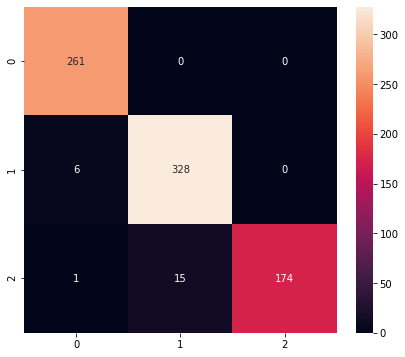

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       261
           1       0.96      0.98      0.97       334
           2       1.00      0.92      0.96       190

    accuracy                           0.97       785
   macro avg       0.98      0.97      0.97       785
weighted avg       0.97      0.97      0.97       785



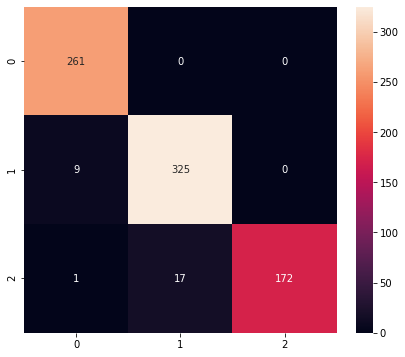

Classification Report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       261
           1       0.95      0.97      0.96       334
           2       1.00      0.91      0.95       190

    accuracy                           0.97       785
   macro avg       0.97      0.96      0.96       785
weighted avg       0.97      0.97      0.97       785



In [147]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g', square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()

    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))


Y_pred = model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
print_confusion_matrix(y_test, y_pred)
print_confusion_matrix(y_test, y_pred1)

In [115]:
model.save(model_save_path, include_optimizer=False)

In [116]:
tflite_save_path = 'gestures_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/y3/zr3jd06j3mnclbzc5l3jdb6w0000gn/T/tmpw4q6rv3a/assets


INFO:tensorflow:Assets written to: /var/folders/y3/zr3jd06j3mnclbzc5l3jdb6w0000gn/T/tmpw4q6rv3a/assets


6368

In [117]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [118]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_details, output_details

([{'name': 'input_7',
   'index': 0,
   'shape': array([ 1, 42], dtype=int32),
   'shape_signature': array([-1, 42], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}],
 [{'name': 'Identity',
   'index': 10,
   'shape': array([1, 3], dtype=int32),
   'shape_signature': array([-1,  3], dtype=int32),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}])

In [119]:
interpreter.set_tensor(input_details[0]['index'], np.array([x_test[0]]))

In [120]:
% % time
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 142 µs, sys: 91 µs, total: 233 µs
Wall time: 220 µs


In [121]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.3607078e-04 9.0390402e-01 9.5659882e-02]
1
